https://stackoverflow.com/questions/7105962/how-do-i-run-a-high-pass-or-low-pass-filter-on-data-points-in-r

I am a beginner in R and I have tried to find information about the following without finding anything.

The green graph in the picture is composed by the red and yellow graphs. But let's say that I only have the data points of something like the green graph. How do I extract the low/high frequencies (i.e. approximately the red/yellow graphs) using a low pass/high pass filter?
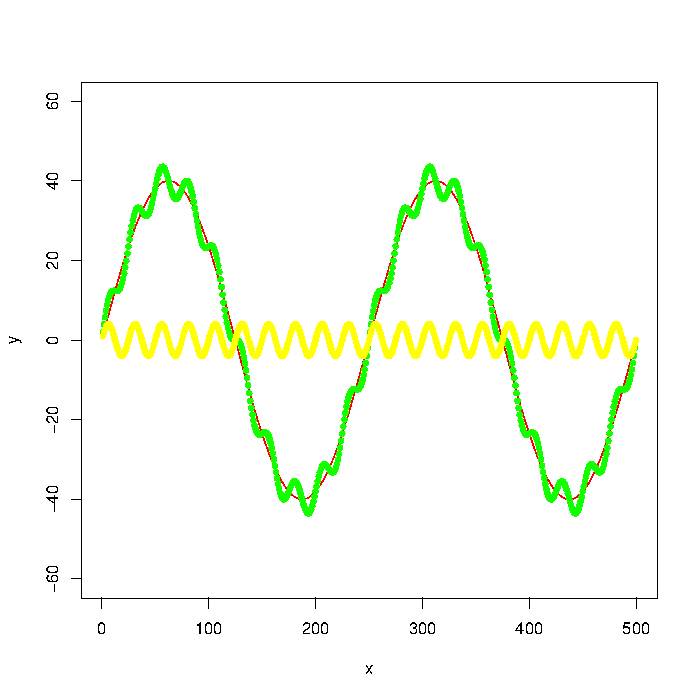

Update: The graph was generated with

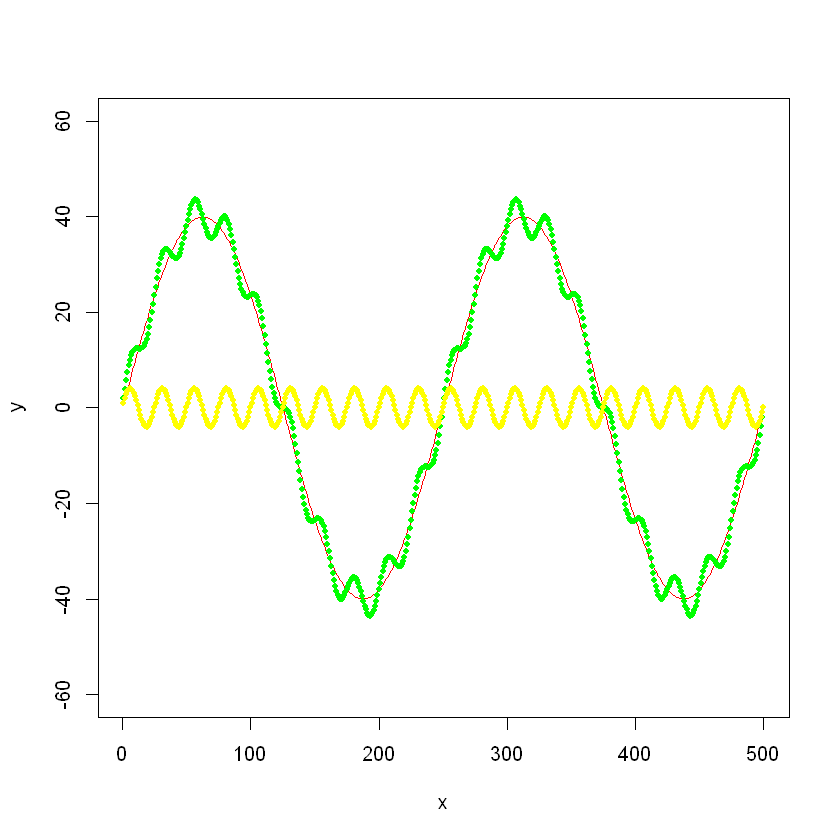

In [1]:
number_of_cycles = 2
max_y = 40

x = 1:500
a = number_of_cycles * 2*pi/length(x)

y = max_y * sin(x*a)
noise1 = max_y * 1/10 * sin(x*a*10)

plot(x, y, type="l", col="red", ylim=range(-1.5*max_y,1.5*max_y,5))
points(x, y + noise1, col="green", pch=20)
points(x, noise1, col="yellow", pch=20)

Update 2: Using the Butterworth filter in the signal package suggested I get the following:
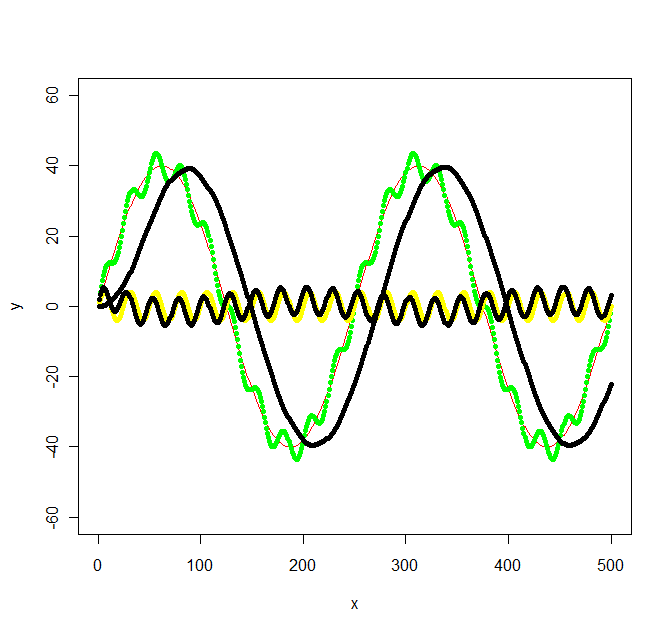

In [4]:
install.packages('signal')

Installing package into 'C:/Users/Mhdella/Documents/R/win-library/3.5'
(as 'lib' is unspecified)


package 'signal' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mhdella\AppData\Local\Temp\Rtmp2HgmzR\downloaded_packages


In [5]:
bf <- butter(2, 1/50, type="low")
b <- filter(bf, y+noise1)
points(x, b, col="black", pch=20)

bf <- butter(2, 1/25, type="high")
b <- filter(bf, y+noise1)
points(x, b, col="black", pch=20)

ERROR: Error in butter(2, 1/50, type = "low"): could not find function "butter"


The calculations was a bit work, signal.pdf gave next to no hints about what values W should have, but the original octave documentation at least mentioned radians which got me going. The values in my original graph was not chosen with any specific frequency in mind, so I ended up with the following not so simple frequencies: f_low = 1/500 * 2 = 1/250, f_high = 1/500 * 2*10 = 1/25 and the sampling frequency f_s = 500/500 = 1. Then I chose a f_c somewhere inbetween the low and high frequencies for the low/high pass filters (1/100 and 1/50 respectively).

=======================================

Different Answer:  (This answer comes late, but I hope it helps someone else struggling with similar problem.)

I bumped into similar problem recently and did not find the answers here particularly helpful. Here is an alternative approach.

Let´s start by defining the example data from the question:

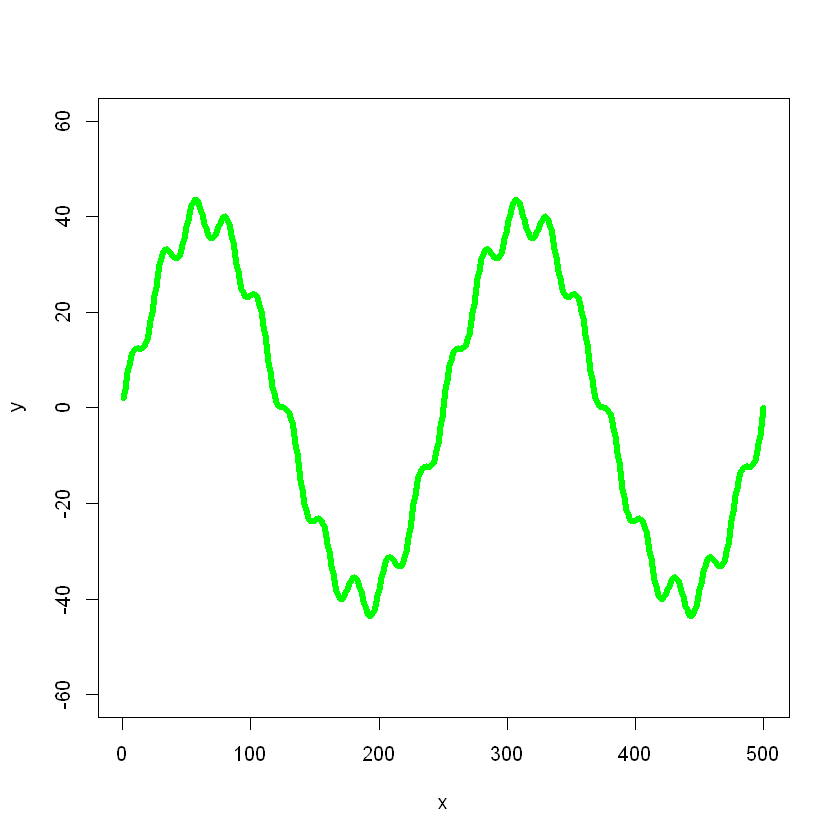

In [33]:
number_of_cycles = 2
max_y = 40

x = 1:500
a = number_of_cycles * 2*pi/length(x)

y = max_y * sin(x*a)
noise1 = max_y * 1/10 * sin(x*a*10)
y <- y + noise1

plot(x, y, type="l", ylim=range(-1.5*max_y,1.5*max_y,5), lwd = 5, col = "green")

So the green line is the dataset we want to low-pass and high-pass filter.

Side note: The line in this case could be expressed as a function by using cubic spline (spline(x,y, n = length(x))), but with real world data this would rarely be the case, so let's assume that it is not possible to express the dataset as a function.

The easiest way to smooth such data I have came across is to use loess or smooth.spline with appropriate span/spar. According to statisticians loess/smooth.spline is probably not the right approach here, as it does not really present a defined model of the data in that sense. An alternative is to use Generalized Additive Models (gam() function from package mgcv). My argument for using loess or smoothed spline here is that it is easier and does not make a difference as we are interested in the visible resulting pattern. Real world datasets are more complicated than in this example and finding a defined function for filtering several similar datasets might be difficult. If the visible fit is good, why to make it more complicated with R2 and p values? To me the application is visual for which loess/smoothed splines are appropriate methods. Both of the methods assume polynomial relationships with the difference that loess is more flexible also using higher degree polynomials, while cubic spline is always cubic (x^2). Which one to use depends on trends in a dataset. That said, the next step is to apply a low-pass filter on the dataset by using loess() or smooth.spline():

In [62]:
lowpass.spline <- smooth.spline(x,y, spar = 0.6) ## Control spar for amount of smoothing
lowpass.loess <- loess(y ~ x, data = data.frame(x = x, y = y), span = 0.3) ## control span to define the amount of smoothing

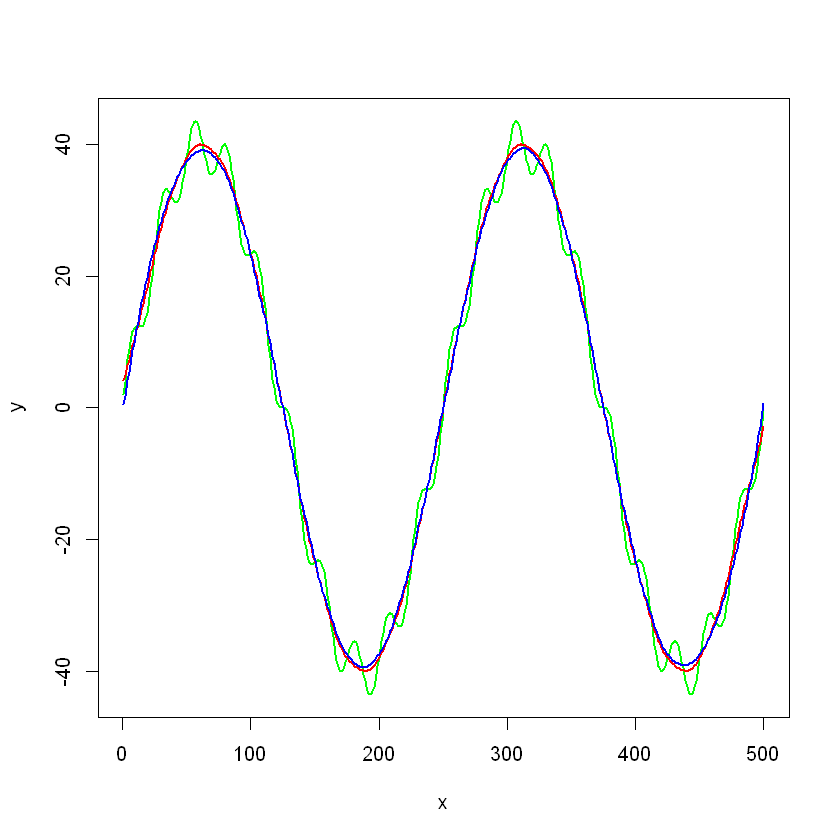

In [63]:
# plot(x,y ,col = "green", lwd = 2)
plot(x,y, type="l",col = "green", lwd = 2)
lines(predict(lowpass.spline, x), col = "red", lwd = 2)
lines(predict(lowpass.loess, x), col = "blue", lwd = 2)

Red line is the smoothed spline filter and blue the loess filter. As you see results differ slightly. I guess one argument of using GAM would be to find the best fit, if the trends really were this clear and consistent among datasets, but for this application both of these fits are good enough for me.

After finding a fitting low-pass filter, the high-pass filtering is as simple as subtracting the low-pass filtered values from y:

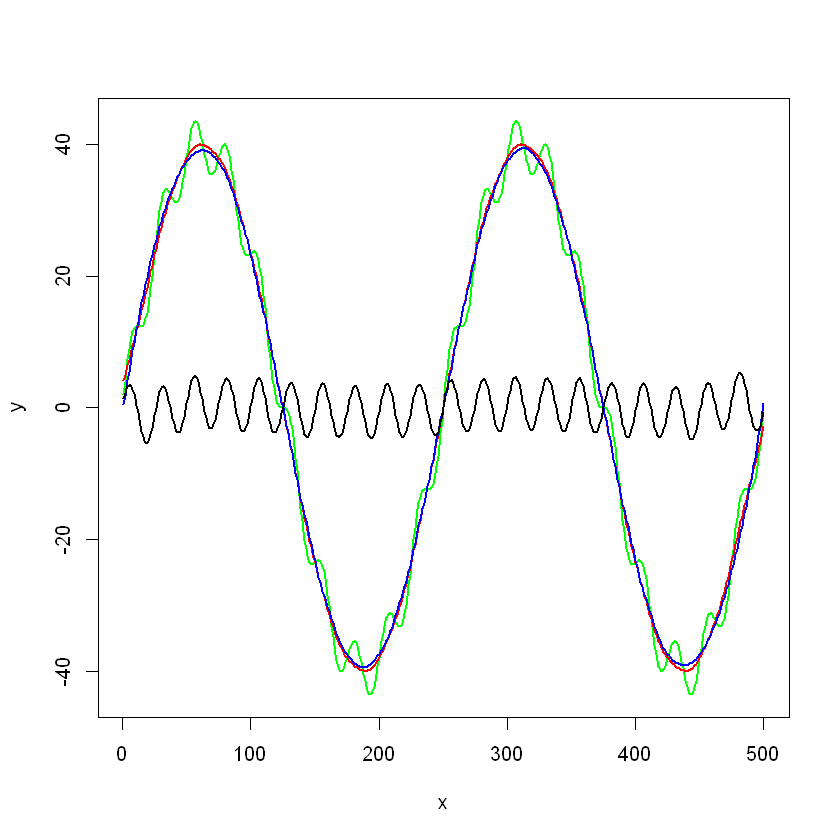

In [60]:
highpass <- y - predict(lowpass.loess, x)

plot(x,y, type="l",col = "green", lwd = 2)
lines(predict(lowpass.spline, x), col = "red", lwd = 2)
lines(predict(lowpass.loess, x), col = "blue", lwd = 2)
lines(x, highpass, lwd =  2)

https://stackoverflow.com/questions/7154133/plot-new-has-not-been-called-yet